In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandasql as sql

In [2]:
#import annual permits and population data
data = pd.read_excel('CBSA_COMBINEDANNUAL_2019.xlsx', header=3)
population = pd.read_csv('cbsa-population.csv', encoding = "ISO-8859-1")

In [3]:
#filter fown dataset
population = (population[['CBSA']+[col for col in population.columns if 'POPESTIMATE' in col]]
              .groupby('CBSA')
              .agg(sum)
              #.reset_index()
             )

#rename columns to years
population.rename(columns={col:col[-4:] for col in population.columns},
                  inplace=True
                 )

#unpivot population table
population = (population
              .unstack()
              .reset_index(name='population_est')
              .rename(columns={'level_0':'year'})
             )

In [4]:
#drop unneeded columns and name needed columns into unique values
data.drop(['HUD\nRegion']+[col for col in data.columns if 'Unnamed' in col],axis=1, inplace=True)

for col in data.columns:
    if data[col].iloc[0] is not np.nan:
        if "." in col:
            renamed_col = f'{col[:4]}_{str(data[col].iloc[0])}'
        else:
            renamed_col = f'{col}_{str(data[col].iloc[0])}'
        data.rename(columns={col:renamed_col},
                    inplace=True
                   )
        

data = data.iloc[1:len(data)-1].reset_index(drop=True)

In [5]:
# unpivot data (columns become rows)
data = (data
        .drop('CBSA\nName',axis=1)
        .set_index('CBSA')
        .unstack()
        .reset_index(name='permits')
        .rename(columns={'level_0':'year'})
        )

In [6]:
#split year-type column into separate columns
def split_cell_0(cell):
    return cell.split('_')[0]

def split_cell_1(cell):
    return cell.split('_')[1]

def filter_nan(string):
    if string != '.':
        return string
    else:
        return np.nan

def filter_out_commas(string):
    if type(string)==str and ',' in string:
        return string.replace(',','')
    else:
        return string

data['house_type'] = data['year'].apply(split_cell_1)
data['year'] = data['year'].apply(split_cell_0)
data = data.merge(population,on=['CBSA','year'],how='inner')
data['permits'] = data['permits'].apply(filter_nan).apply(filter_out_commas)

data.to_csv('permits_and_population.csv',index=False)

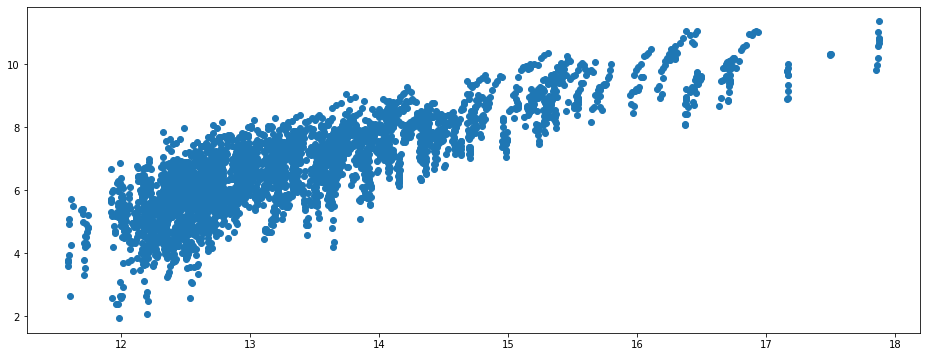

In [7]:
plt.figure(figsize=(16,6))
plt.scatter(np.log1p(data[data.house_type=='Total'].dropna().population_est),
            np.log1p(data[data.house_type=='Total'].dropna().permits.astype(int))
           )